## Timeseries Analysis of Stats NZ Trade Data

This notebook analyzes Stats NZ trade data covering the period from January 2014 to September 2022. The data set includes export and import values for goods and services in NZ$ categorized by country, quarter and 2-digit Harmonised System (HS) codes. 

The table can be accessed on the following website: 
<a href='https://statisticsnz.shinyapps.io/trade_dashboard/'>Stats NZ Trade Dashboard</a>

#### 1. Data loading

In [1]:
#import python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#set plotting style and size

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16,6]

In [2]:
#read data into dataframe df

file = '../data/Tradedata.csv'

quarter_date_parser = lambda x: datetime.strptime(x, '%Y%m')
df = pd.read_csv(file, parse_dates=['Period'], date_parser=quarter_date_parser, index_col='Period')
df.index.rename('Quarter', inplace=True)
df.sort_values(by='Quarter', inplace=True)

In [3]:
#display dataframe

df.head(5)

,Country Code,Country,Account,Category,Code,Flag,Total Value (NZD),Description
Quarter,,,,,,,,
2014-06-01,AF,Afghanistan,Imports,Goods,00,F,131905.0,Total
2014-06-01,PT,Portugal,Imports,Goods,42,F,1471.0,Leather products
2014-06-01,PT,Portugal,Imports,Goods,44,F,378323.0,Wood
2014-06-01,PT,Portugal,Imports,Goods,45,F,361186.0,Cork
2014-06-01,PT,Portugal,Imports,Goods,48,F,142718.0,Paper products


#### 2. Data cleaning

The dataset containes 413815 rows and 9 columns for the period between 2014-06-01 and 2022-09-01
The trade values of exports and imports are aggregated per quarters. 

In [4]:
#information about dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413815 entries, 2014-06-01 to 2022-09-01
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Country Code       413179 non-null  object 
 1   Country            413751 non-null  object 
 2   Account            413815 non-null  object 
 3   Category           413815 non-null  object 
 4   Code               413815 non-null  object 
 5   Flag               413815 non-null  object 
 6   Total Value (NZD)  413815 non-null  float64
 7   Description        413815 non-null  object 
dtypes: float64(1), object(7)
memory usage: 28.4+ MB


Rows with missing country names or zero trade values were removed from the data frame.   

In [5]:
#rows with zero trade values

print('Number of missing values from the Country column:', df['Country'].isnull().sum())
print('Number of rows with zero trade values:', df[df['Total Value (NZD)'] == 0].shape[0] )

Number of missing values from the Country column: 64
Number of rows with zero trade values: 30429


In [6]:
#filter dataframe

df1 = df[df['Total Value (NZD)'] != 0]
print('Number of rows with zero trade values:', df1[df1['Total Value (NZD)'] == 0].shape[0] )

Number of rows with zero trade values: 0


#### 3. Overview of exported and imported goods 

The input data file includes two types of trades: goods and services, such as imports and exports. Products are labeled with two-digit codes, where '00' represents the total value of all exported and imported products per country.

In [7]:
#create dataframes for goods

goods_exports= df1[(df1['Account']=='Exports') & (df1['Category']=='Goods') ]
goods_imports= df1[(df1['Account']=='Imports') & (df1['Category']=='Goods') ]

print('Exports:', goods_exports.shape, 'Imports:', goods_imports.shape)

Exports: (164196, 8) Imports: (185076, 8)


In [8]:
#find number of distinctive Level 2 HS Codes 

print('Number of unique codes for exports and imports:', goods_exports[goods_exports['Code']!='00']['Code'].nunique(),',', goods_imports[goods_imports['Code']!='00']['Code'].nunique())

Number of unique codes for exports and imports: 97 , 97


In [9]:
#Find the number of countries where products are exported or imported.

countries_perquarter_exp = goods_exports.groupby('Quarter')['Country'].nunique()
countries_perquarter_imp = goods_imports.groupby('Quarter')['Country'].nunique()

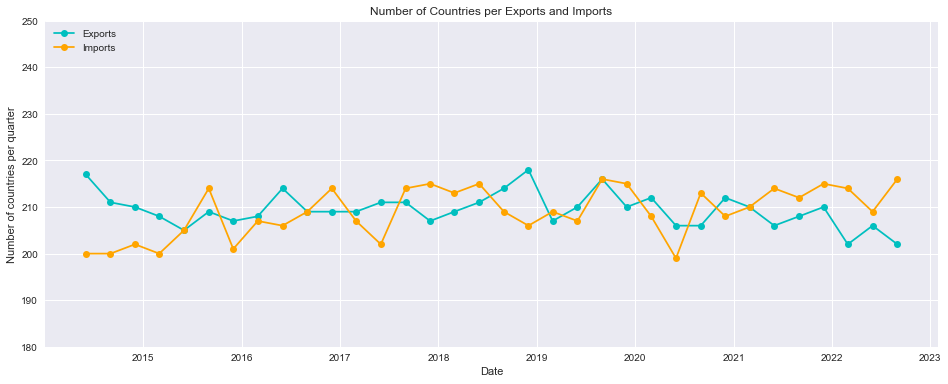

In [10]:
#plot number of countries per quarter

fig,ax = plt.subplots()
line1=ax.plot(countries_perquarter_exp.index, countries_perquarter_exp.values, color = 'c', marker='o',label='Exports')
line2=ax.plot(countries_perquarter_imp.index, countries_perquarter_imp.values, color = 'orange', marker='o', label='Imports')

ax.set_xlabel('Date')
ax.set_title('Number of Countries per Exports and Imports')
ax.set_ylabel('Number of countries per quarter')
plt.ylim(180,250)
plt.legend(loc='upper left')
plt.show()

#### Note: 
The number of countries importing and exporting products is similar, ranging between 200 and 220 per quarter.

#### 4. Data preparation

##### Goods

In [11]:
#total exports and imports per country
goods_exports_country_total = df[(df['Account']=='Exports') & (df['Category']=='Goods')  & (df['Description']=='Total') & (df['Country']!='Total all countries')]
goods_imports_country_total = df[(df['Account']=='Imports') & (df['Category']=='Goods')  & (df['Description']=='Total') & (df['Country']!='Total all countries')]

#subset dataframes
goods_exports_country_total = goods_exports_country_total[['Country Code', 'Country', 'Total Value (NZD)']]
goods_imports_country_total = goods_imports_country_total[['Country Code', 'Country', 'Total Value (NZD)']]

#transform and rename columns 
goods_exports_country_total['Total Value (NZD)'] = round(goods_exports_country_total['Total Value (NZD)'].div(1000),2)   
goods_exports_country_total.rename(columns={'Country Code':'CountryCode', 'Total Value (NZD)':'ValuesInThousandsNZD'}, inplace = True)   

goods_imports_country_total['Total Value (NZD)'] = round(goods_imports_country_total['Total Value (NZD)'].div(1000),2)   
goods_imports_country_total.rename(columns={'Country Code':'CountryCode', 'Total Value (NZD)':'ValuesInThousandsNZD'}, inplace = True)   

In [12]:
#total exports and imports for all countries
goods_exports_total = df[(df['Account']=='Exports') & (df['Category']=='Goods')  & (df['Description']=='Total') & (df['Country']=='Total all countries')]
goods_imports_total = df[(df['Account']=='Imports') & (df['Category']=='Goods')  & (df['Description']=='Total') & (df['Country']=='Total all countries')]

#values of exports and imports in billions $NZ
goods_exports_total = goods_exports_total[['Total Value (NZD)']]
goods_exports_total['Total Value (NZD)'] = round(goods_exports_total['Total Value (NZD)'].div(1000000000),2)
goods_exports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

goods_imports_total = goods_imports_total[['Total Value (NZD)']]
goods_imports_total['Total Value (NZD)'] = round(goods_imports_total['Total Value (NZD)'].div(1000000000),2)
goods_imports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

##### Services

Exported and imported services are labeled with two- and four-digit 'A' codes.

In [13]:
#create dataframe of services
services_exports= df[(df['Account']=='Exports') & (df['Category']=='Services') ]
services_imports= df[(df['Account']=='Imports') & (df['Category']=='Services') ]

print('Exports of services:', services_exports.shape, 'Imports of services:', services_imports.shape)

Exports of services: (35756, 8) Imports of services: (28787, 8)


In [14]:
print('The time period for Services is between' , services_exports.index.min(), 'quarter and ', services_exports.index.max(), 'quarter')

The time period for Services is between 2014-06-01 00:00:00 quarter and  2022-09-01 00:00:00 quarter


In [15]:
#number of countries for each code 
services_exp = services_exports.groupby('Code')['Country'].nunique()

services_imp = services_imports.groupby('Code')['Country'].nunique()
print(pd.merge(services_exp, services_imp, left_on=services_exp.index, right_on=services_imp.index, how='left'))

    key_0  Country_x  Country_y
0     A12        242        240
1   A1202         60         67
2   A1203         61         64
3   A1204        241        234
4   A1205         61         65
5   A1206         54         49
6   A1207        150         74
7   A1208        163        123
8   A1209        178        174
9   A1210        212        210
10  A1211        164        121
11  A1212        234         49


In [16]:
#total exports and imports per country
services_exports_country_total = df[(df['Account']=='Exports') & (df['Category']=='Services')  & (df['Description']=='Total') & (df['Country']!='Total all countries')]
services_imports_country_total = df[(df['Account']=='Imports') & (df['Category']=='Services')  & (df['Description']=='Total') & (df['Country']!='Total all countries')]

#subset of dataframe
services_exports_country_total = services_exports_country_total[['Country Code', 'Country', 'Total Value (NZD)']]
services_imports_country_total = services_imports_country_total[['Country Code', 'Country', 'Total Value (NZD)']]

In [17]:
#total exports and imports per quarters for all countries
services_exports_total = df[(df['Account']=='Exports') & (df['Category']=='Services')  & (df['Description']=='Total') & (df['Country']=='Total all countries')]
services_imports_total = df[(df['Account']=='Imports') & (df['Category']=='Services')  & (df['Description']=='Total') & (df['Country']=='Total all countries')]

#values of exports and imports in billions $NZ
services_exports_total = services_exports_total[['Total Value (NZD)']]
services_exports_total['Total Value (NZD)'] = round(services_exports_total['Total Value (NZD)'].div(1000000000),2)
services_exports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

services_imports_total = services_imports_total[['Total Value (NZD)']]
services_imports_total['Total Value (NZD)'] = round(services_imports_total['Total Value (NZD)'].div(1000000000),2)
services_imports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

#### 5. Total exports and imports

In [18]:
#total trades including both goods and services
total_trade_exports=services_exports_total.merge(goods_exports_total, left_index=True, right_index=True)
total_trade_imports=services_imports_total.merge(goods_imports_total, left_index=True, right_index=True)

total_trade_exports['ValueOfGoodsandServices'] = total_trade_exports['ValuesInBillionsNZD_x']+ total_trade_exports['ValuesInBillionsNZD_y']
total_trade_imports['ValueOfGoodsandServices'] = total_trade_imports['ValuesInBillionsNZD_x']+ total_trade_imports['ValuesInBillionsNZD_y']

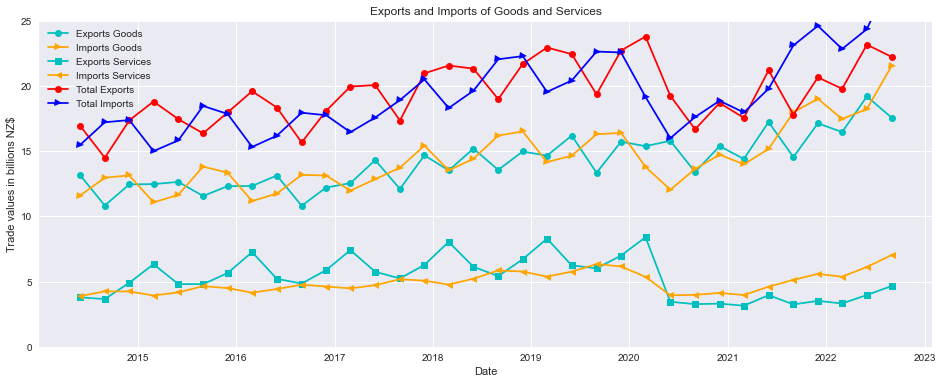

In [19]:
fig,ax = plt.subplots()

line1 = ax.plot(goods_exports_total.index, goods_exports_total.values, color = 'c', marker='o',label='Exports Goods')
line2 = ax.plot(goods_imports_total.index, goods_imports_total.values, color = 'orange', marker='>', label='Imports Goods')
line3 = ax.plot(services_exports_total.index, services_exports_total.values, color = 'c', marker='s',label='Exports Services')
line4 = ax.plot(services_imports_total.index, services_imports_total.values, color = 'orange', marker='<', label='Imports Services')

line5 = ax.plot(total_trade_exports.index, total_trade_exports.ValueOfGoodsandServices, color = 'red', marker='o', label='Total Exports')
line6 = ax.plot(total_trade_imports.index, total_trade_imports.ValueOfGoodsandServices, color = 'blue', marker='>', label='Total Imports')

ax.set_xlabel('Date')
ax.set_title('Exports and Imports of Goods and Services')
ax.set_ylabel('Trade values in billions NZ$')
plt.ylim(0,25)
plt.legend(loc = 'upper left')
plt.show()

This graph shows the quarterly export and import values for Goods and Services, along with the total trade values (Goods + Services). A dip around 2021 indicates changes in trade activity during the COVID-19 pandemic.

#### 6. Countries with the highest values of goods exports

In [20]:
#maximum exports per quarter and per country

df3 = goods_exports_country_total.groupby(['Quarter', 'Country']).agg({'ValuesInThousandsNZD': sum})
df4 = df3.sort_values('ValuesInThousandsNZD', ascending = 0)

In [21]:
#pivot the table by country and sort from max to min

goods_exports_country_total_pivot = pd.pivot_table(goods_exports_country_total,
                                    values='ValuesInThousandsNZD',
                                    index='Quarter',
                                    columns='Country',
                                    aggfunc=np.mean)

In [22]:
#countries with the maximum exports

df_temp = goods_exports_country_total_pivot
df_row = df_temp[df_temp.index == df_temp.index[1]].sort_values(by = df_temp.index[1], axis = 1, ascending = False) 

for i in range(2, len(df_temp.index)):
    df_row1 = df_temp[df_temp.index == df_temp.index[i]].sort_values(by = df_temp.index[i], axis = 1, ascending = False)
    dfm = df_row.iloc[:,0:5].append(df_row1.iloc[:,0:5])
    df_row = dfm 

In [23]:
#resampling to the values of exports per Year

df_export_perYear = df_row.resample("Y"). sum() 
df_export_perYear.index.rename('Year', inplace=True)
df_export_perYear.index = df_export_perYear.index.strftime('%Y')

print(df_export_perYear.head(5))

Country   Australia  China, People's Republic of  United States of America  \
Year                                                                         
2014     4541222.89                   4069436.39                2333029.80   
2015     8339522.92                   8611422.68                5757781.15   
2016     8277020.16                   9432047.60                5298580.47   
2017     8807782.04                  12094098.59                5324927.94   
2018     9063086.10                  13847432.01                5501167.26   

Country       Japan  Korea, Republic of  Indonesia  
Year                                                
2014     1427776.75           905950.40        0.0  
2015     2952502.96           418224.12        0.0  
2016     2974982.66           692047.11        0.0  
2017     3205408.47           792611.44        0.0  
2018     3493899.41          1744697.07        0.0  


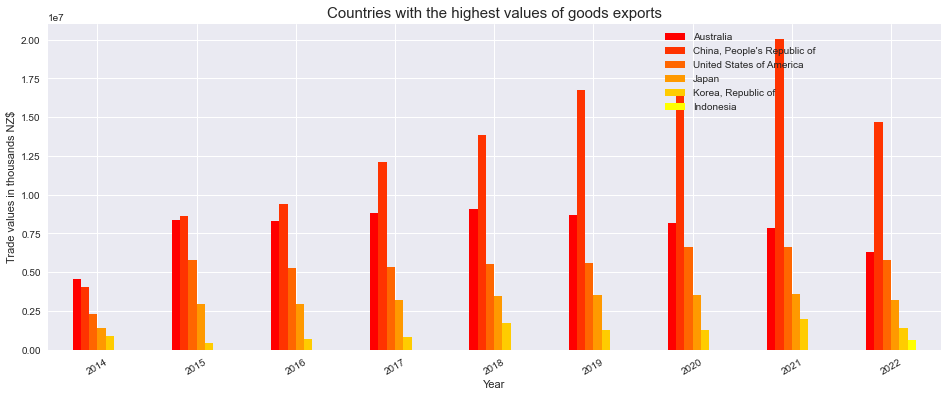

In [24]:
#countries with the highest values of goods exports 

color_map=plt.cm.get_cmap('autumn')
ax = df_export_perYear.plot(kind='bar', cmap = color_map) 

plt.xticks(rotation=30, horizontalalignment='center')
ax.set_title('Countries with the highest values of goods exports', fontsize=15)
ax.set_ylabel('Trade values in thousands NZ$')
#ax.set_xlim(2015,2022)
ax.legend(loc='upper right', bbox_to_anchor=(0.87,1.0))
plt.show()

Export values increase year by year, with the highest exports going to Australia and China. 

#### 7. Countries with the highest values of goods imports

In [25]:
#Maximum imports per quarter and per country

df1 = goods_imports_country_total.groupby(['Quarter', 'Country']).agg({'ValuesInThousandsNZD': sum})
df2 = df1.sort_values('ValuesInThousandsNZD', ascending = 0)

In [26]:
#pivot the table by countries and sort from max to min

goods_imports_country_total_pivot = pd.pivot_table(goods_imports_country_total,
                                    values='ValuesInThousandsNZD',
                                    index='Quarter',
                                    columns='Country',
                                    aggfunc=np.mean)

In [27]:
#countries with the maximum imports 

df_temp = goods_imports_country_total_pivot
df_row = df_temp[df_temp.index == df_temp.index[1]].sort_values(by = df_temp.index[1], axis = 1, ascending = False) 


for i in range(2, len(df_temp.index)):
    df_row1 = df_temp[df_temp.index == df_temp.index[i]].sort_values(by = df_temp.index[i], axis = 1, ascending = False)
    dfm = df_row.iloc[:,0:5].append(df_row1.iloc[:,0:5])
    df_row = dfm

In [28]:
#resampling to values of goods imports per Year

df_import_perYear = df_row.resample("Y"). sum() 
df_import_perYear.index.rename('Year', inplace=True)
df_import_perYear.index = df_import_perYear.index.strftime('%Y')

print(df_import_perYear.head(5))

Country  China, People's Republic of  United States of America   Australia  \
Year                                                                         
2014                      4662841.94                3319151.80  3292469.94   
2015                      9883514.86                5891415.80  5952382.72   
2016                      9957539.15                5573594.12  6220759.03   
2017                     10536296.29                5760941.14  6641390.48   
2018                     12076149.26                6107054.99  7006301.54   

Country       Japan     Germany  Singapore  
Year                                        
2014     1616990.33  1252916.14        0.0  
2015     3143949.18  2335192.03        0.0  
2016     3382375.24  1796056.99        0.0  
2017     3864148.16  2283650.89        0.0  
2018     4112662.95        0.00        0.0  


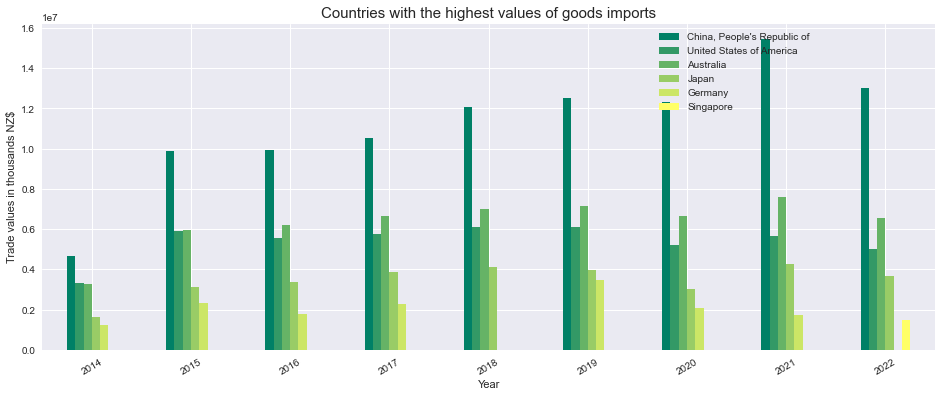

In [29]:
#countries with the highest values of goods imports

color_map=plt.cm.get_cmap('summer')
ax = df_import_perYear.plot(kind='bar', cmap = color_map) 

plt.xticks(rotation=30, horizontalalignment='center')
ax.set_title('Countries with the highest values of goods imports', fontsize=15)
ax.set_ylabel('Trade values in thousands NZ$')
#ax.set_xlim(2015,2022)
ax.legend(loc='upper right', bbox_to_anchor=(0.87,1.0))
plt.show()

Import values increase year by year, with the highest imports comming from China and United States of America. 

#### 8. Countries with the highest values of services exports 

In [30]:
#maximum exports per quarter and per country

dfs1 = services_exports_country_total.groupby(['Quarter', 'Country']).agg({'Total Value (NZD)': sum})
dfs2 = dfs1.sort_values('Total Value (NZD)', ascending = 0)

In [31]:
#pivot the table by countries and sort from max to min

services_exports_country_total_pivot = pd.pivot_table(services_exports_country_total,
                                       values='Total Value (NZD)',
                                       index='Quarter',
                                       columns='Country',
                                       aggfunc=np.mean)

In [32]:
#countries with the maximum exports 

df_temp = services_exports_country_total_pivot
df_row = df_temp[df_temp.index == df_temp.index[1]].sort_values(by = df_temp.index[1], axis = 1, ascending = False) 

for i in range(2, len(df_temp.index)):
    df_row1 = df_temp[df_temp.index == df_temp.index[i]].sort_values(by = df_temp.index[i], axis = 1, ascending = False)
    dfm = df_row.iloc[:,0:5].append(df_row1.iloc[:,0:5])
    df_row = dfm

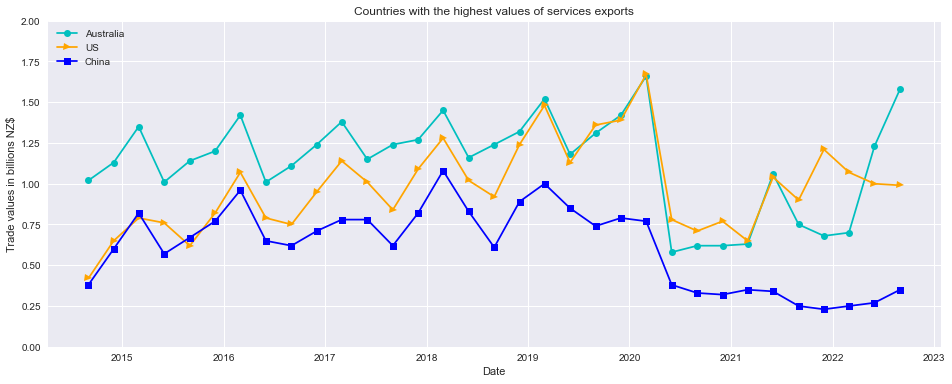

In [33]:
#countries with the highest values of services exports

fig,ax = plt.subplots()

line1 = ax.plot(df_row.index, (df_row.iloc[:,0]/1000000000).round(2).values, color = 'c', marker='o', label='Australia')
line2 = ax.plot(df_row.index, (df_row.iloc[:,1]/1000000000).round(2).values, color = 'orange', marker='>', label='US')
line3 = ax.plot(df_row.index, (df_row.iloc[:,2]/1000000000).round(2).values, color = 'blue', marker='s', label='China')
ax.set_xlabel('Date')
ax.set_title('Countries with the highest values of services exports')
ax.set_ylabel('Trade values in billions NZ$')
plt.ylim(0,2)
plt.legend(loc = 'upper left')
plt.show()

New Zealand exported the highest value of services (in NZ dollars) to Australia and the United States, with China ranking third. There was a noticable decline in exports during the COVID-19 pandemic. 

#### 9. Countries with the highest values of services imports

In [34]:
#maximum imports per quarter and per country

dfs3 = services_imports_country_total.groupby(['Quarter', 'Country']).agg({'Total Value (NZD)': sum})
dfs4 = dfs3.sort_values('Total Value (NZD)', ascending = 0)

In [35]:
#pivot the table by countries and sort from max to min

services_imports_country_total_pivot = pd.pivot_table(services_imports_country_total,
                                       values='Total Value (NZD)',
                                       index='Quarter',
                                       columns='Country',
                                       aggfunc=np.mean)

In [36]:
#Countries with the maximum imports
i
df_tempi = services_imports_country_total_pivot
df_rowi = df_tempi[df_tempi.index == df_tempi.index[1]].sort_values(by = df_tempi.index[1], axis = 1, ascending = False) 

for i in range(2, len(df_tempi.index)):
    df_row1i = df_tempi[df_tempi.index == df_tempi.index[i]].sort_values(by = df_tempi.index[i], axis = 1, ascending = False)
    dfmi = df_rowi.iloc[:,0:5].append(df_row1i.iloc[:,0:5])
    df_rowi = dfmi

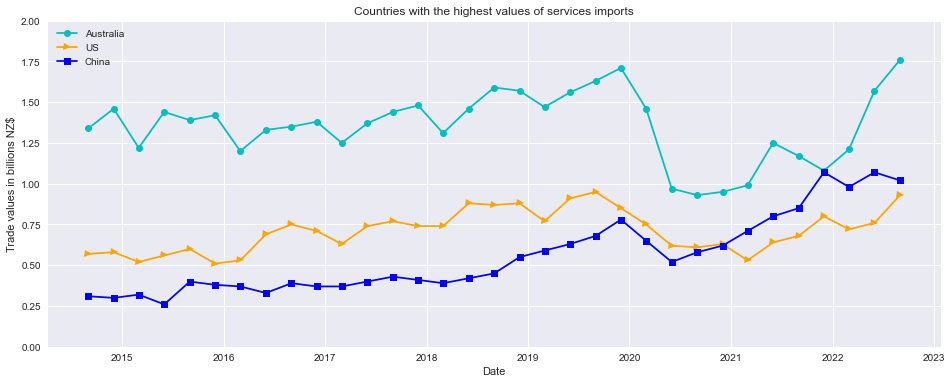

In [37]:
#countries with the highest values of services imports

fig,ax = plt.subplots()

line1 = ax.plot(df_rowi.index, (df_rowi.iloc[:,0]/1000000000).round(2).values, color = 'c', marker='o', label='Australia')
line2 = ax.plot(df_rowi.index, (df_rowi.iloc[:,1]/1000000000).round(2).values, color = 'orange', marker='>', label='US')
line3 = ax.plot(df_rowi.index, (df_rowi.iloc[:,2]/1000000000).round(2).values, color = 'blue', marker='s', label='China')
ax.set_xlabel('Date')
ax.set_title('Countries with the highest values of services imports')
ax.set_ylabel('Trade values in billions NZ$')
plt.ylim(0,2)
plt.legend(loc = 'upper left')
plt.show()

New Zealand imported the highest value of services (in NZ dollars) from Australia and the United States, with China moved into second place in the last couple of years.There was a noticable decline in imports during the COVID-19 pandemic. 

#### 10. Top Exports 

In [38]:
#exports and imports per product

goods_exports_product_total = df[(df['Account']=='Exports') & (df['Category']=='Goods')  & (df['Code']!='00') & (df['Country']!='Total all countries')]
goods_imports_product_total = df[(df['Account']=='Imports') & (df['Category']=='Goods')  & (df['Code']!='00') & (df['Country']!='Total all countries')]


In [39]:
#group exported product values by quarters 

dfprod = goods_exports_product_total.groupby(['Quarter', 'Code', 'Description']).agg({'Total Value (NZD)': sum})
dfprod2 = dfprod.sort_values('Total Value (NZD)', ascending = False)

In [40]:
#sum exported product values by year and sort

dfprod3 = dfprod2.reset_index()

dfprod3['Year']= dfprod3['Quarter'].dt.strftime('%Y')
dfprod3 = dfprod3.groupby(['Year', 'Code', 'Description']).agg({'Total Value (NZD)': sum})/1000000000
dfprod4 = dfprod3.sort_values(by=['Year','Total Value (NZD)'], ascending = False)

In [41]:
#separate multi-index column and extract the top 5 values for each year

dfprod4.reset_index(inplace=True) 
dfprod5 = dfprod4.groupby('Year').head(5).reset_index(drop=True)
print(dfprod5.head(5))

   Year Code                                   Description  Total Value (NZD)
0  2022   04                                         Dairy          14.538167
1  2022   02                         Meat and edible offal           7.793962
2  2022   44                                          Wood           3.883505
3  2022   08                               Fruits and nuts           3.537725
4  2022   19  Milk preparations, pasta and baking products           1.777765


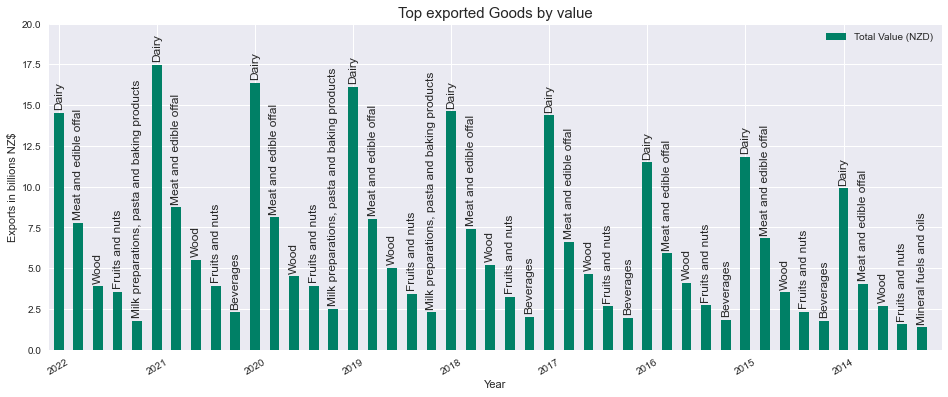

In [42]:
#Countries with the highest values of exports between 2015 and 2022

dfprod5.set_index('Year', inplace = True)

color_map=plt.cm.get_cmap('summer')
dfprod5.plot(kind='bar', color=color_map(np.linspace(0, 1, len(dfprod5))))

for i in range(len(dfprod5)):
   plt.text(i, dfprod5['Total Value (NZD)'][i] + 0.2, dfprod5['Description'][i], ha='center', va='bottom', rotation='vertical', fontsize = 'large')

plt.xticks(rotation=30, horizontalalignment='center')
plt.xticks(np.arange(0, len(dfprod5.index)+1, 5))
plt.title('Top exported Goods by value', fontsize=15)
plt.xlabel('Year')
plt.ylim(0,20)

plt.ylabel('Exports in billions NZ$')
plt.show()

New Zealand's primarly exports were dairy, meat and wood between 2014 and 2022.  

#### 11. Top Imports

In [43]:
#group imported product values by quarters 

dfimp = goods_imports_product_total.groupby(['Quarter', 'Code', 'Description']).agg({'Total Value (NZD)': sum})
dfimp2 = dfimp.sort_values('Total Value (NZD)', ascending = False)

In [44]:
#sum imported product values by year and sort

dfimp3 = dfimp2.reset_index()

dfimp3['Year']= dfimp3['Quarter'].dt.strftime('%Y')
dfimp3 = dfimp3.groupby(['Year', 'Code', 'Description']).agg({'Total Value (NZD)': sum})/1000000000
dfimp6 = dfimp3.sort_values(by=['Year','Total Value (NZD)'], ascending = False)

In [45]:
#separate multi-index column and extract the top 5 imports for each year

dfimp6.reset_index(inplace=True) 
dfimp7 = dfimp6.groupby('Year').head(5).reset_index(drop=True)

print(dfimp7.head(5))

   Year Code                         Description  Total Value (NZD)
0  2022   84                Mechanical machinery           7.759340
1  2022   87                            Vehicles           7.435990
2  2022   27              Mineral fuels and oils           6.673254
3  2022   85  Electrical machinery and equipment           5.011385
4  2022   39                            Plastics           2.029731


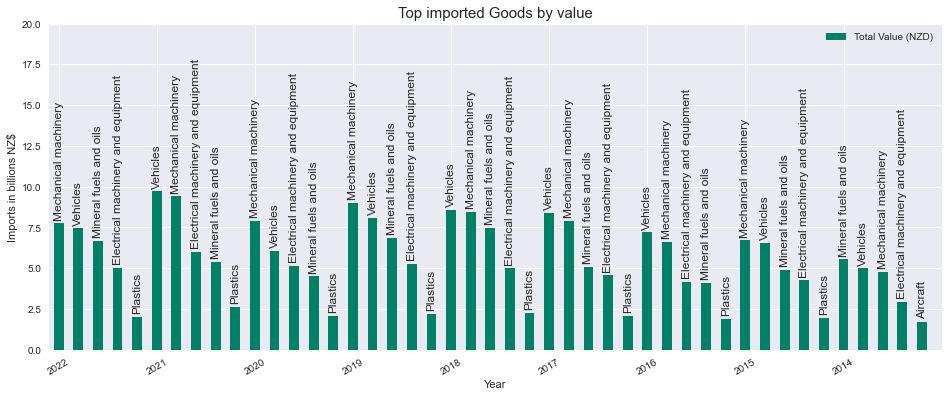

In [46]:
#countries with the highest values of exports between 2015 and 2022

dfimp7.set_index('Year', inplace = True)

color_map=plt.cm.get_cmap('summer')
dfimp7.plot(kind='bar', color=color_map(np.linspace(0, 1, len(dfimp7))))

for i in range(len(dfimp7)):
   plt.text(i, dfimp7['Total Value (NZD)'][i] + 0.2, dfimp7['Description'][i], ha='center', va='bottom', rotation='vertical', fontsize = 'large')

plt.xticks(rotation=30, horizontalalignment='center')
plt.xticks(np.arange(0, len(dfimp7.index)+1, 5))
plt.title('Top imported Goods by value', fontsize=15)
plt.xlabel('Year')
plt.ylim(0,20)

plt.ylabel('Imports in billions NZ$')
plt.show()

New Zealand's main imports include mechanical machinery and vehicles. 